In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import h5py


In [ ]:
X, y = load_breast_cancer(return_X_y=True)
print('X.shape=', X.shape)
print('Y.shape=', y.shape)
print('*'*20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=0
)

for name, arr in zip(['X_train', 'X_test', 'y_train', 'y_test'], [X_train, X_test, y_train, y_test]):
    print(f'{name}: {arr.shape}')


X.shape= (569, 30)
Y.shape= (569,)
********************
X_train: (398, 30)
X_test: (171, 30)
y_train: (398,)
y_test: (171,)


In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier())
])

param_grid = {
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': [1e-4, 1e-3, 1e-2],
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__max_iter': [500]
}

search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    verbose=True
)

search.fit(X_train, y_train)
print('Test score:', round(search.score(X_test, y_test), 3))
print('Train score', round(search.score(X_train, y_train), 3))


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Test score: 0.971
Train score 0.997


In [ ]:
best_model = search.best_estimator_.named_steps['mlp']


# Signs dataset

In [ ]:
cwd = os.getcwd()  # current working directory
path = os.path.join(cwd, 'data')

# signs data set (fingers)


def load_dataset():
    fn = os.path.join(path, 'train_signs.h5')
    train_dataset = h5py.File(fn, "r")
    # your train set features
    X_train = np.array(train_dataset["train_set_x"][:])
    # your train set labels
    y_train = np.array(train_dataset["train_set_y"][:])

    fn = os.path.join(path, 'test_signs.h5')
    test_dataset = h5py.File(fn, "r")
    X_test = np.array(test_dataset["test_set_x"][:])  # your test set features
    y_test = np.array(test_dataset["test_set_y"][:])  # your test set labels

    classes = np.array(test_dataset["list_classes"][:])  # the list of classes

    y_train = y_train.reshape((1, y_train.shape[0]))
    y_test = y_test.reshape((1, y_test.shape[0]))

    return X_train, y_train, X_test, y_test, classes


In [ ]:
X_train, y_train, X_test, y_test, classes = load_dataset()
y_train = y_train.ravel()
y_test = y_test.ravel()

for name, arr in zip(['X_train', 'y_train', 'X_test', 'y_test'], [X_train, y_train, X_test, y_test]):
    print(f"{name}: {arr.shape}")


X_train: (1080, 64, 64, 3)
y_train: (1080,)
X_test: (120, 64, 64, 3)
y_test: (120,)


In [ ]:
def display_samples_in_grid(X, n_rows, n_cols=None, y=None):
    if n_cols is None:
        n_cols = n_rows
    indices = np.random.randint(0, len(X), n_rows*n_cols)
    for i in range(n_rows):
        for j in range(n_cols):
            index = n_rows*i+j
            ax = plt.subplot(n_rows, n_cols, index+1)
            plt.imshow(X[indices[index]])
            if not (y is None):
                plt.title(y[indices[index]])
            plt.axis('off')

    plt.tight_layout(h_pad=1)


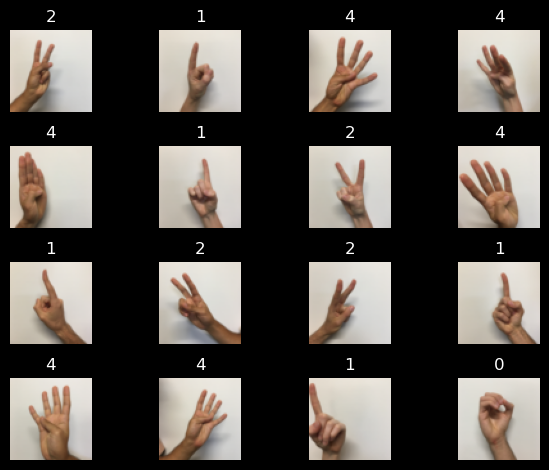

In [ ]:
plt.figure()
display_samples_in_grid(X_train, n_rows=4, y=y_train)
plt.show()


In [ ]:
plt.gcf().canvas.manager.set_window_title('Train set')


In [ ]:
# Preprocess data
# START_CODE
X_train_flatten = X_train.reshape(X_train.shape[0], -1).T
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T

X_train_scaled = X_train_flatten / 255
X_test_scaled = X_test_flatten / 255

print("number of training examples = " + str(X_train_scaled.shape[1]))
print("number of test examples = " + str(X_test_scaled.shape[1]))
print("X_train_scaled shape: " + str(X_train_scaled.shape))

print("X_test_scaled shape: " + str(X_test_scaled.shape))
# END_CODE


number of training examples = 1080
number of test examples = 120
X_train_scaled shape: (12288, 1080)
X_test_scaled shape: (12288, 120)


In [ ]:
# Train classifier and evaluate performance
# START_CODE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
X_train_pca = pca.fit_transform(X_train_scaled.T)
X_test_pca = pca.transform(X_test_scaled.T)

clf = RandomizedSearchCV(pipeline,
                         param_distributions=param_grid,
                         verbose=True,
                         n_iter=20,
                         cv=3,
                         n_jobs=-1,)

clf.fit(X_train_scaled.T, y_train)

train_acc = clf.score(X_train_scaled.T, y_train)
test_acc = clf.score(X_test_scaled.T,  y_test)

print("train accuracy= {:.3%}".format(train_acc))
print("test accuracy=  {:.3%}".format(test_acc))
# END_CODE


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


train accuracy= 100.000%
test accuracy=  93.333%


<Figure size 640x480 with 0 Axes>

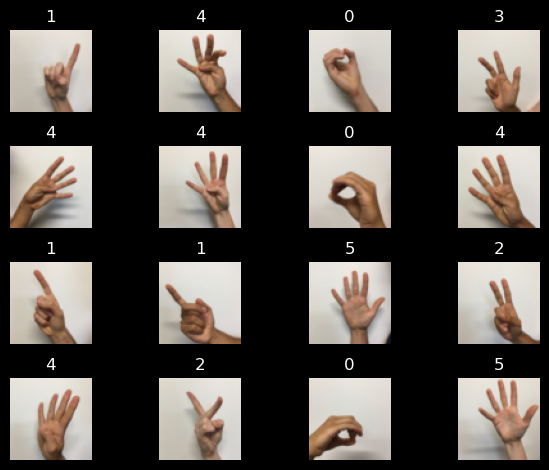

In [ ]:
plt.figure()
display_samples_in_grid(X_train, n_rows=4, y=y_train)
plt.show()


# Compare with SVM

In [ ]:
from sklearn.svm import SVC


In [ ]:
clf = SVC(C=10, kernel='rbf', gamma=0.001).fit(X_train_scaled.T, y_train)
print("train accuracy= {:.3%}".format(clf.score(X_train_scaled.T, y_train)))
print("test accuracy= {:.3%}".format(clf.score(X_test_scaled.T, y_test)))


train accuracy= 99.907%
test accuracy= 95.833%
